#  K Means

**"A popular clustering method using an iterative refinement technique"**



## Pregled
* K Means

## K Means
* Prvi algoritam nesuperviziranog učenja koji obrađujemo
* Klasteruje podatke u K klastera, gde je K predefinisana vrednost
* Na početku su klasteri odabrani nasumično i izračunati njihovi centroidi, a zatim ponavljamo (do konvergencije) naredna dva koraka:
  * **Assignment step**: svakoj tački dodelimo klaster sa najbližim centroidom (Voronoi particija)
  * **Update step**: računamo nove centroide za svaki klaster
* Može se pokazati da ovaj algoritam zapravo minimizuje sumu kvadratnih udaljenosti svake tačke od njenog centroida
  * Assignment step fiksira centroide i pravi dodelu tako da minimizuje udaljenosti do njih
  * Update step fiksira dodelu klastera i postavlja centroide tako da minimizuje udaljenosti do njih
* Kako opisana funkcija troška nije konveksna, moguće je da se zaglavimo u lokalnim minimumima
  * Pokrenuti više puta
* Kako odabrati pravo K?
  * **Elbow method** nad funkcijom troška
* Resurs: [cs229](http://cs229.stanford.edu/notes/cs229-notes7a.pdf)


## Implementacija (TensorFlow i sklearn)
- Nakon ovog koda se nalazi implementacija u čistom python-u (tj. numpy) sa kojom ćemo porediti rezultate

Podaci:
[[71.24 28.  ]
 [52.53 25.  ]
 [64.54 27.  ]
 [55.69 22.  ]]


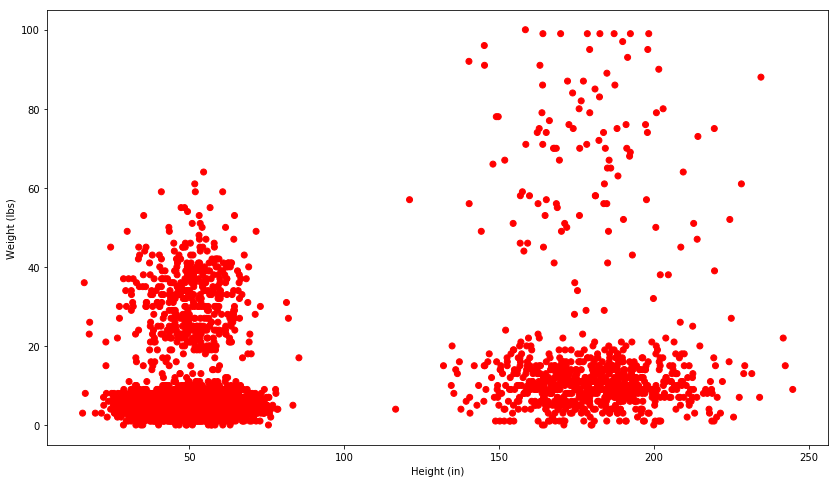

Iteracija 1: delta = 8.74958324432373
Iteracija 2: delta = 4.588191032409668
Iteracija 3: delta = 0.632566511631012
Iteracija 4: delta = 0.04175835847854614
Iteracija 5: delta = 0.015913009643554688
Iteracija 6: delta = 0.013514339923858643
Iteracija 7: delta = 0.0
TF:


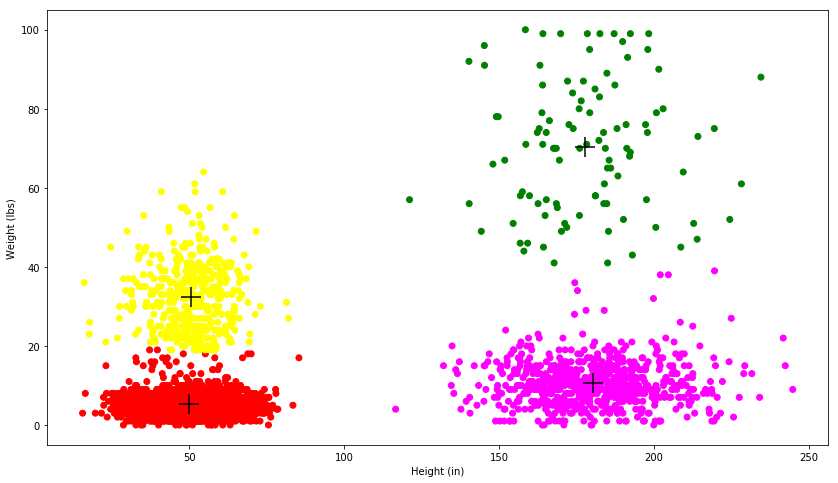

Loss:719601.538347454
sklearn:


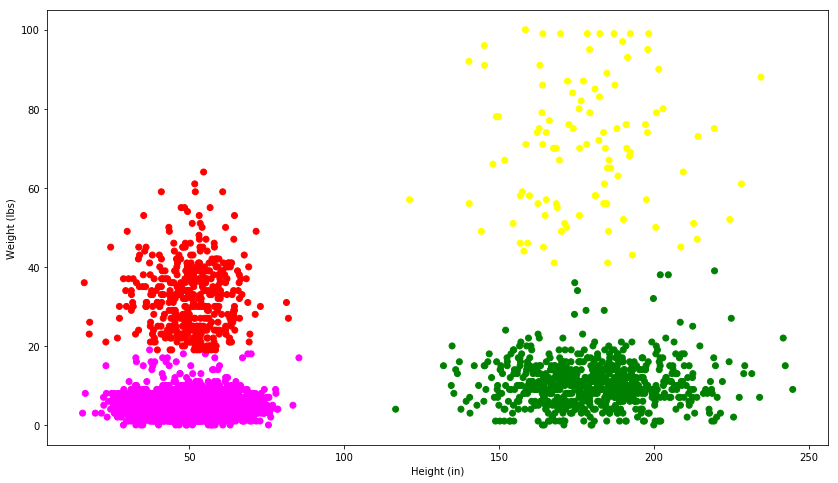

In [15]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Iskljucuje ispis stvari manje vaznosti od ERROR-a 
tf.logging.set_verbosity(tf.logging.ERROR)

# Pravi scatter plot podataka i klastera
def scatter_plot(X, Y, assignments=None, centers=None):
    
    # Ako nismo prosledili assignment-e neka su svi dodeljeni klasteru 0
    if assignments is None:
        assignments = [0] * len(X)
    
    # Pravimo veliki plot
    fig = plt.figure(figsize=(14,8))
     
    # Kolor mapa za klastere (za k=5, za manje k ce biti odabrane neke 4 boje)
    cmap = ListedColormap(['red', 'green', 'blue', 'magenta', 'yellow'])
    
    # Scatter plot
    plt.scatter(X, Y, c=assignments, cmap=cmap)
   
    # Nacrtati centre ako postoje
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1],
                    marker='+', s=400, color='black')  
    
    # Oznake osa
    plt.xlabel('Height (in)')
    plt.ylabel('Weight (lbs)')
    plt.show()

# Ucitavanje podataka
#data = np.loadtxt('kmeans_data.csv', delimiter=',', usecols=(1, 2))
data = np.loadtxt('kmeans_data_drivers.csv', skiprows=1, delimiter='\t', usecols=(1, 2))
print("Podaci:")
print(data[:4])
    
# Scater plot samo podataka
scatter_plot(data[:, 0], data[:, 1])

# K-means
# tf.contrib.factorization.KMeansClustering zahteva podatke kao input_fn
k = 4
input_fn=lambda: tf.train.limit_epochs(tf.convert_to_tensor(data, dtype=tf.float32), num_epochs=1)
kmeans = tf.contrib.factorization.KMeansClustering(use_mini_batch=False, num_clusters=k)

# Radimo K-means iteracije dok azuriranje centroida nije premalo ili nismo 
# premasili maksimalan broj iteracija
previous_centers = None

delta = 100
eps = 1e-3

iters = 0
max_iters = 100

while delta > eps and iters < max_iters:
  kmeans.train(input_fn = input_fn)
  centers = kmeans.cluster_centers()
  if previous_centers is not None:
    delta = np.average(np.abs(centers - previous_centers))
    print('Iteracija {}: delta = {}'.format(iters, delta))
  previous_centers = centers
  iters += 1

# Izvlacimo dodele i centre i plotujemo
assignments = list(kmeans.predict_cluster_index(input_fn))
print("TF:")
scatter_plot(data[:, 0], data[:, 1], assignments, centers)

# Racunamo funkciju troska
print("Loss:{}".format(np.sum(np.square(centers[assignments] - data))))

# sklearn implementacija, za poredjenje
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4).fit(data)
print("sklearn:")
scatter_plot(data[:, 0], data[:, 1], kmeans.labels_)

## Implementacija (čist python / numpy)

Podaci:
[[71.24 28.  ]
 [52.53 25.  ]
 [64.54 27.  ]
 [55.69 22.  ]]


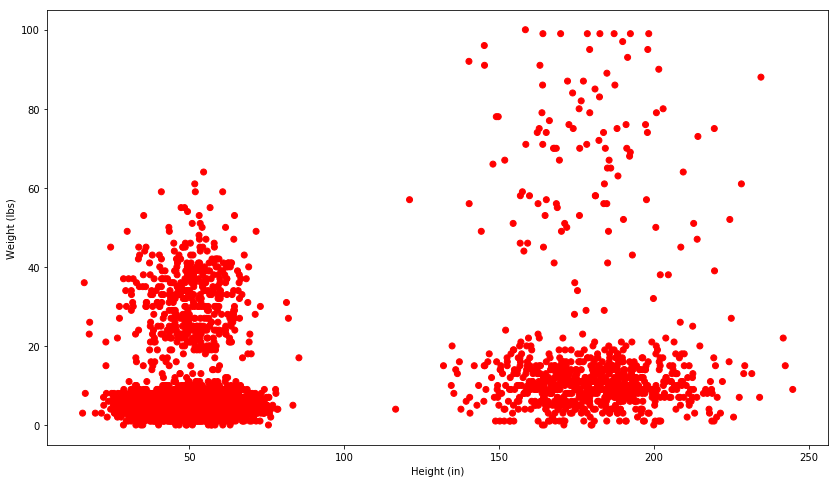

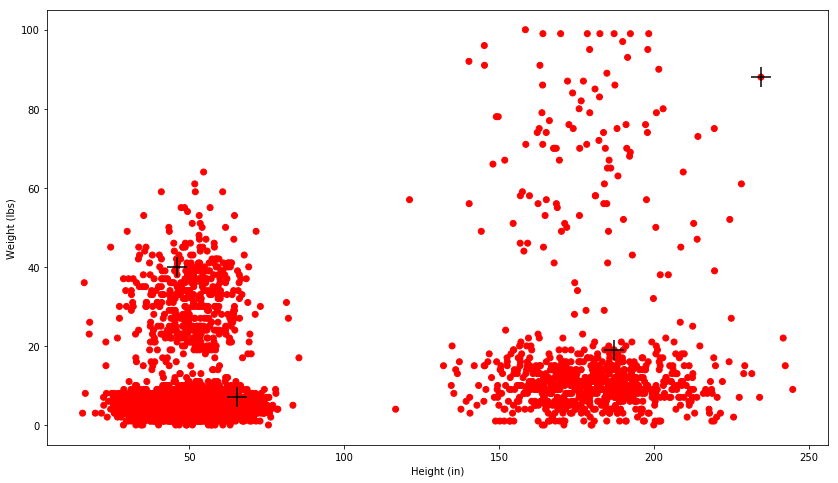

Iteracija 1: delta = 3.4583299190203785
Iteracija 2: delta = 0.8067316901693948
Iteracija 3: delta = 0.08766008470397146
Iteracija 4: delta = 0.0
Numpy:


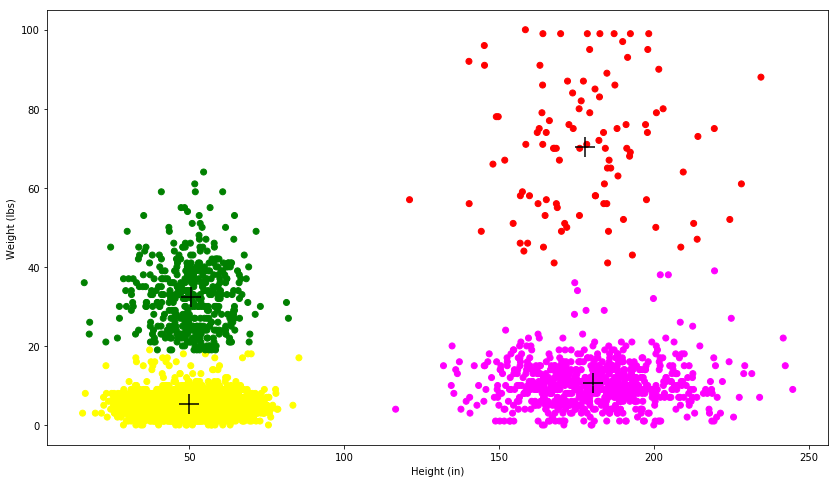

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import numpy as np
%matplotlib inline

# Koristimo istu plot funkciju od malopre
tf.logging.set_verbosity(tf.logging.ERROR)
def scatter_plot(X, Y, assignments=None, centers=None):
    
    # Ako nismo prosledili assignment-e neka su svi dodeljeni klasteru 0
    if assignments is None:
        assignments = [0] * len(X)
    
    # Pravimo veliki plot
    fig = plt.figure(figsize=(14,8))
     
    # Kolor mapa za klastere (za k=5, za manje k ce biti odabrane neke 4 boje)
    cmap = ListedColormap(['red', 'green', 'blue', 'magenta', 'yellow'])
    
    # Scatter plot
    plt.scatter(X, Y, c=assignments, cmap=cmap)
   
    # Nacrtati centre ako postoje
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1],
                    marker='+', s=400, color='black')
    
    # Oznake osa
    plt.xlabel('Height (in)')
    plt.ylabel('Weight (lbs)')
    plt.show()

# K means: prima podatke i K a vraca niz assignmenta (lista)
# i niz centara (numpy)
def kmeans(data, k):
  # Inicijalizacija, biramo nausumicnih k tacaka iz podataka da budu centri
  # i dodeljujemo svima centar 0
  num_examples = data.shape[0]
  centers = data[random.sample(range(num_examples), k)]
  assignments = [0] * num_examples
  
  # Kriterijumi za zaustavljanje
  delta = 100
  eps = 1e-3

  iters = 0
  max_iters = 100
  
  previous_centers = None
  
  # Jedna iteracija
  scatter_plot(data[:, 0], data[:, 1], assignments, centers)
  while delta > eps and iters < max_iters:
    
    # Assignment step
    for i in range(num_examples):
      dists = np.linalg.norm(centers - data[i], axis=1)
      assignments[i] = np.argmin(dists)
    
    # Update step
    centers = np.zeros((k, 2))
    cluster_sizes = np.zeros(k)
    for i in range(num_examples):
      cluster_idx = assignments[i]
      centers[cluster_idx] += data[i]
      cluster_sizes[cluster_idx] += 1
    for i in range(k):
      if cluster_sizes[i] == 0:
        raise RuntimeError('Empty cluster?')
      centers[i] /= cluster_sizes[i]
      
    # Update centara i priprema za novu iteraciju
    if previous_centers is not None:
      delta = np.average(np.abs(centers - previous_centers))
      print('Iteracija {}: delta = {}'.format(iters, delta))
    previous_centers = centers
    iters += 1 
  return assignments, centers
    
    
# Ucitavanje podataka
#data = np.loadtxt('kmeans_data.csv', delimiter=',', usecols=(1, 2))
data = np.loadtxt('kmeans_data_drivers.csv', skiprows=1, delimiter='\t', usecols=(1, 2))
print("Podaci:")
print(data[:4])
    
# Scater plot samo podataka
scatter_plot(data[:, 0], data[:, 1])

# K-means
# tf.contrib.factorization.KMeansClustering zahteva podatke kao input_fn
k = 4
assignments, centers = kmeans(data, k)  
    
# Plot
# Algoritam pravilno konvergira ali ne uvek u globalni optimum
# Ovo najvise zavisi od nacina inicijalizacije koji je u nasem slucaju dosta
# jednostavan (pogledati KMeans++ https://en.wikipedia.org/wiki/K-means%2B%2B)
print("Numpy:")
scatter_plot(data[:, 0], data[:, 1], assignments, centers)